In [ ]:
!pip install pandas numpy scikit-learn xgboost keras tensorflow matplotlib

In [ ]:
!pip install tensorflow

In [ ]:
# Install the specific version of TensorFlow
!pip install tensorflow==2.15.1

In [ ]:
!pip install scikeras==0.12.0


In [ ]:
!pip install keras>=3.2.0
!pip install scikeras

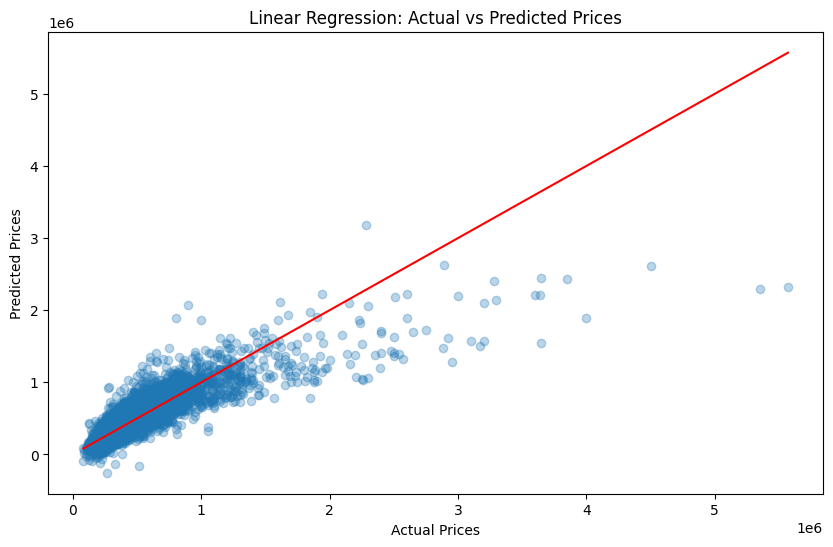

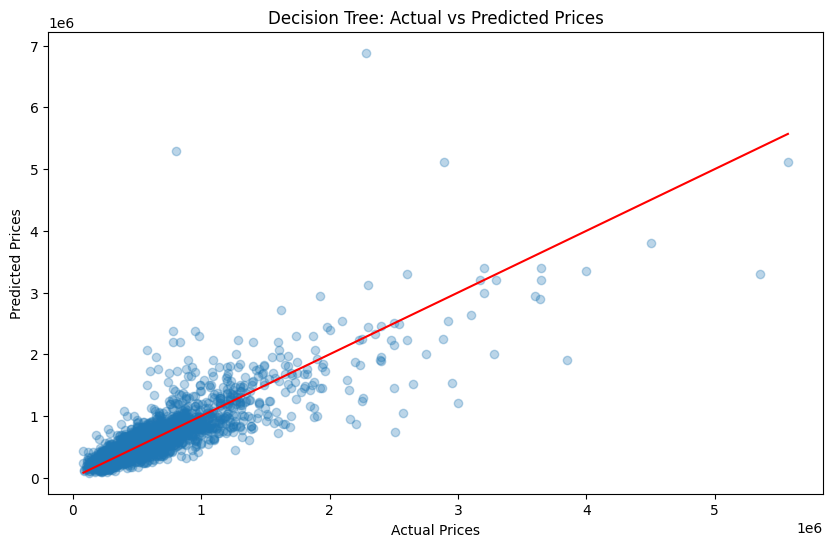

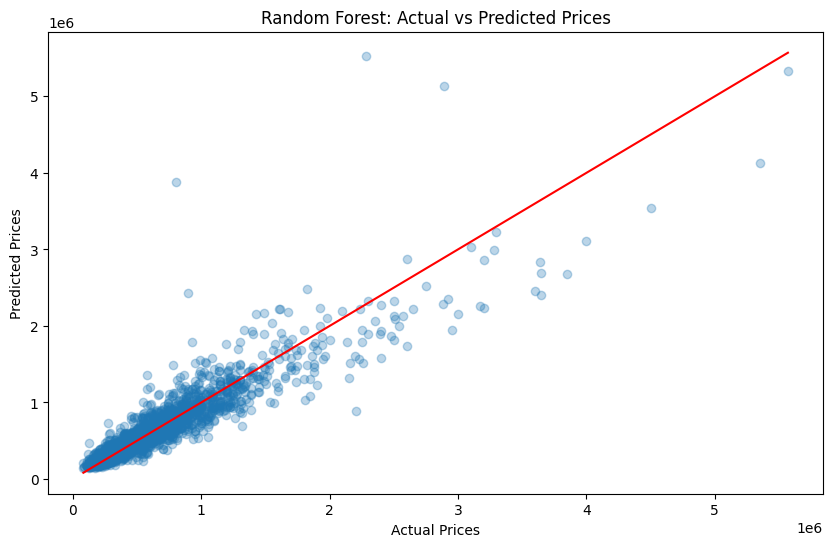

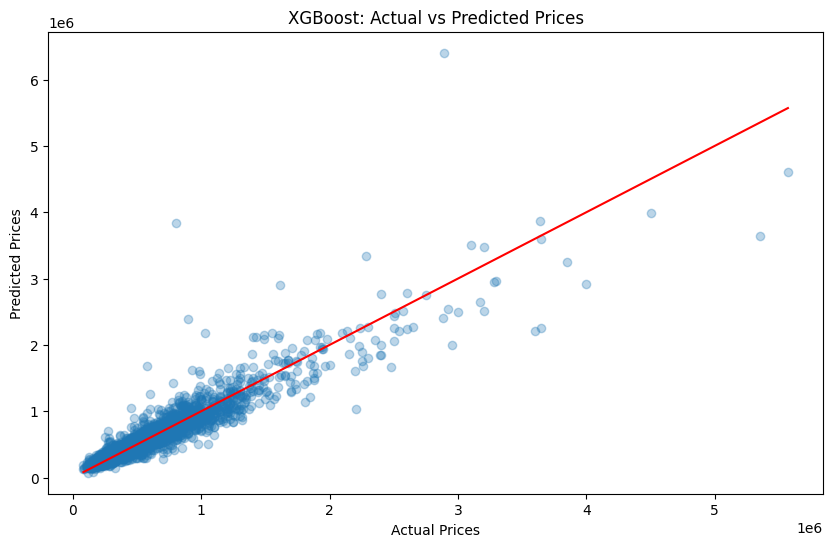

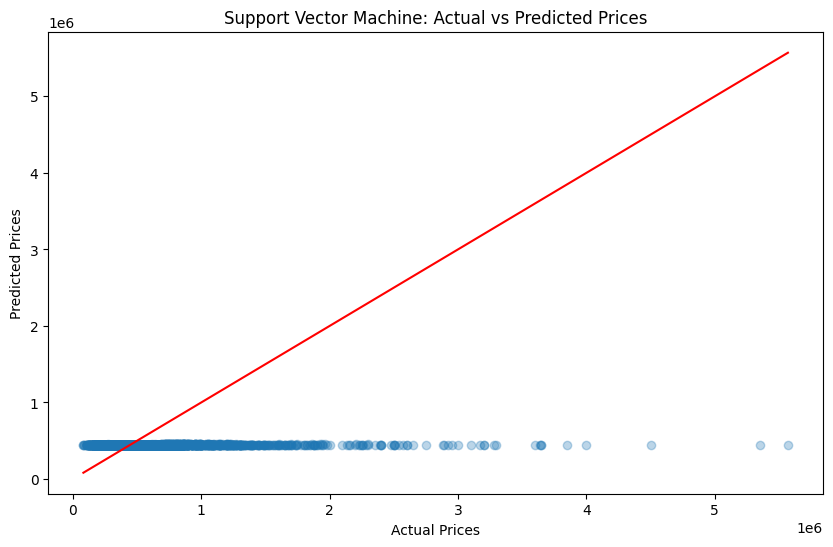

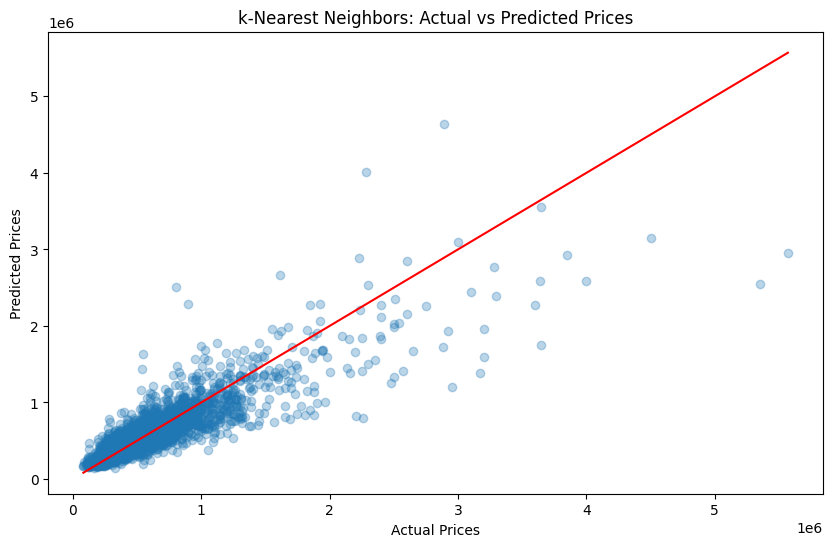

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


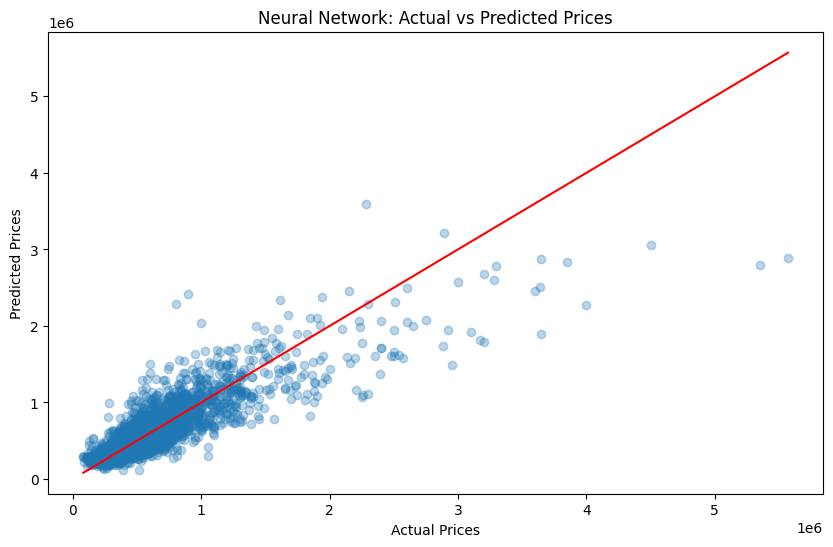

Linear Regression: RMSE = 212036.1654, R² = 0.7026
Decision Tree: RMSE = 211372.5139, R² = 0.7045
Random Forest: RMSE = 150257.8166, R² = 0.8507
XGBoost: RMSE = 142414.6545, R² = 0.8658
Support Vector Machine: RMSE = 400942.5278, R² = -0.0634
k-Nearest Neighbors: RMSE = 186712.8618, R² = 0.7694
Neural Network: RMSE = 191165.3486, R² = 0.7583


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
# Import KerasRegressor from scikeras
from scikeras.wrappers import KerasRegressor
#from keras.wrappers.scikit_learn import KerasRegressor
#Import joblib to save and load models
import joblib
# Import StandardScaler
from sklearn.preprocessing import StandardScaler


# Load the dataset
data = pd.read_csv('kc_house_data.csv')

# Selecting relevant features
features = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "waterfront", "view", "condition", "grade", "sqft_above",
    "sqft_basement", "yr_built", "yr_renovated"
]

# Preprocessing
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
#data = data.drop(columns=['id', 'date'])
#data = data.dropna()

# Split the data into features and target variable
#X = data.drop('price', axis=1)
#y = data['price']

# Define features and target
X = data[features + ['zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month']]
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Helper function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Plotting the predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name}: Actual vs Predicted Prices')
    plt.show()

    return rmse, r2

# Models and their evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'Support Vector Machine': SVR(),
    'k-Nearest Neighbors': KNeighborsRegressor()
}

results = {}

for model_name, model in models.items():
    rmse, r2 = evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    results[model_name] = {'RMSE': rmse, 'R²': r2}

# Neural Network
def build_nn():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn_model = KerasRegressor(build_fn=build_nn, epochs=50, batch_size=32, verbose=0)
nn_rmse, nn_r2 = evaluate_model(nn_model, X_train, y_train, X_test, y_test, 'Neural Network')
results['Neural Network'] = {'RMSE': nn_rmse, 'R²': nn_r2}

# Print the results
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R²']:.4f}")


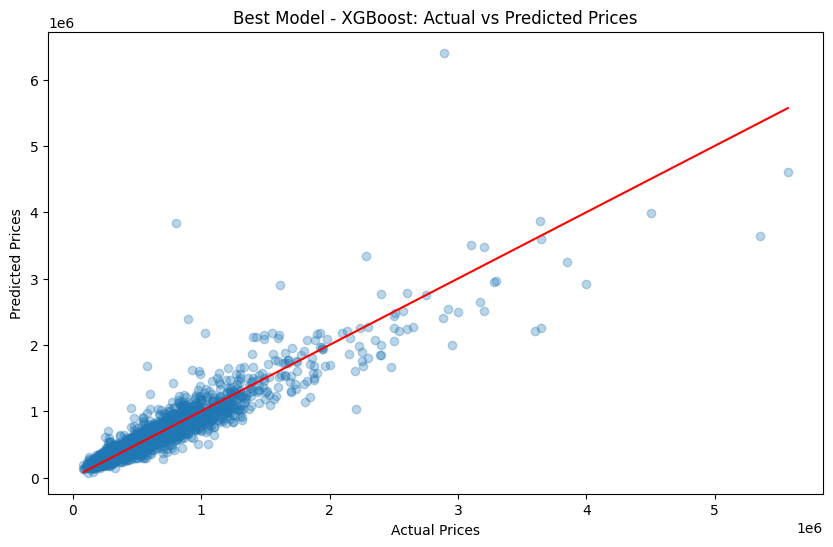

['model_columns.pkl']

In [ ]:
# Select the best model
best_model_name = min(results, key=lambda k: results[k]['RMSE'])
best_model = models[best_model_name] if best_model_name != 'Neural Network' else nn_model

# Train the best model on the entire dataset
best_model.fit(X_train, y_train)

# Visualize the best model
evaluate_model(best_model, X_train, y_train, X_test, y_test, f'Best Model - {best_model_name}')

# Predict function for user input
def predict_price(input_data):
    input_df = pd.DataFrame([input_data], columns=X.columns)
    predicted_price = best_model.predict(input_df)
    return predicted_price[0]
# Save the best model
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(X.columns, 'model_columns.pkl')


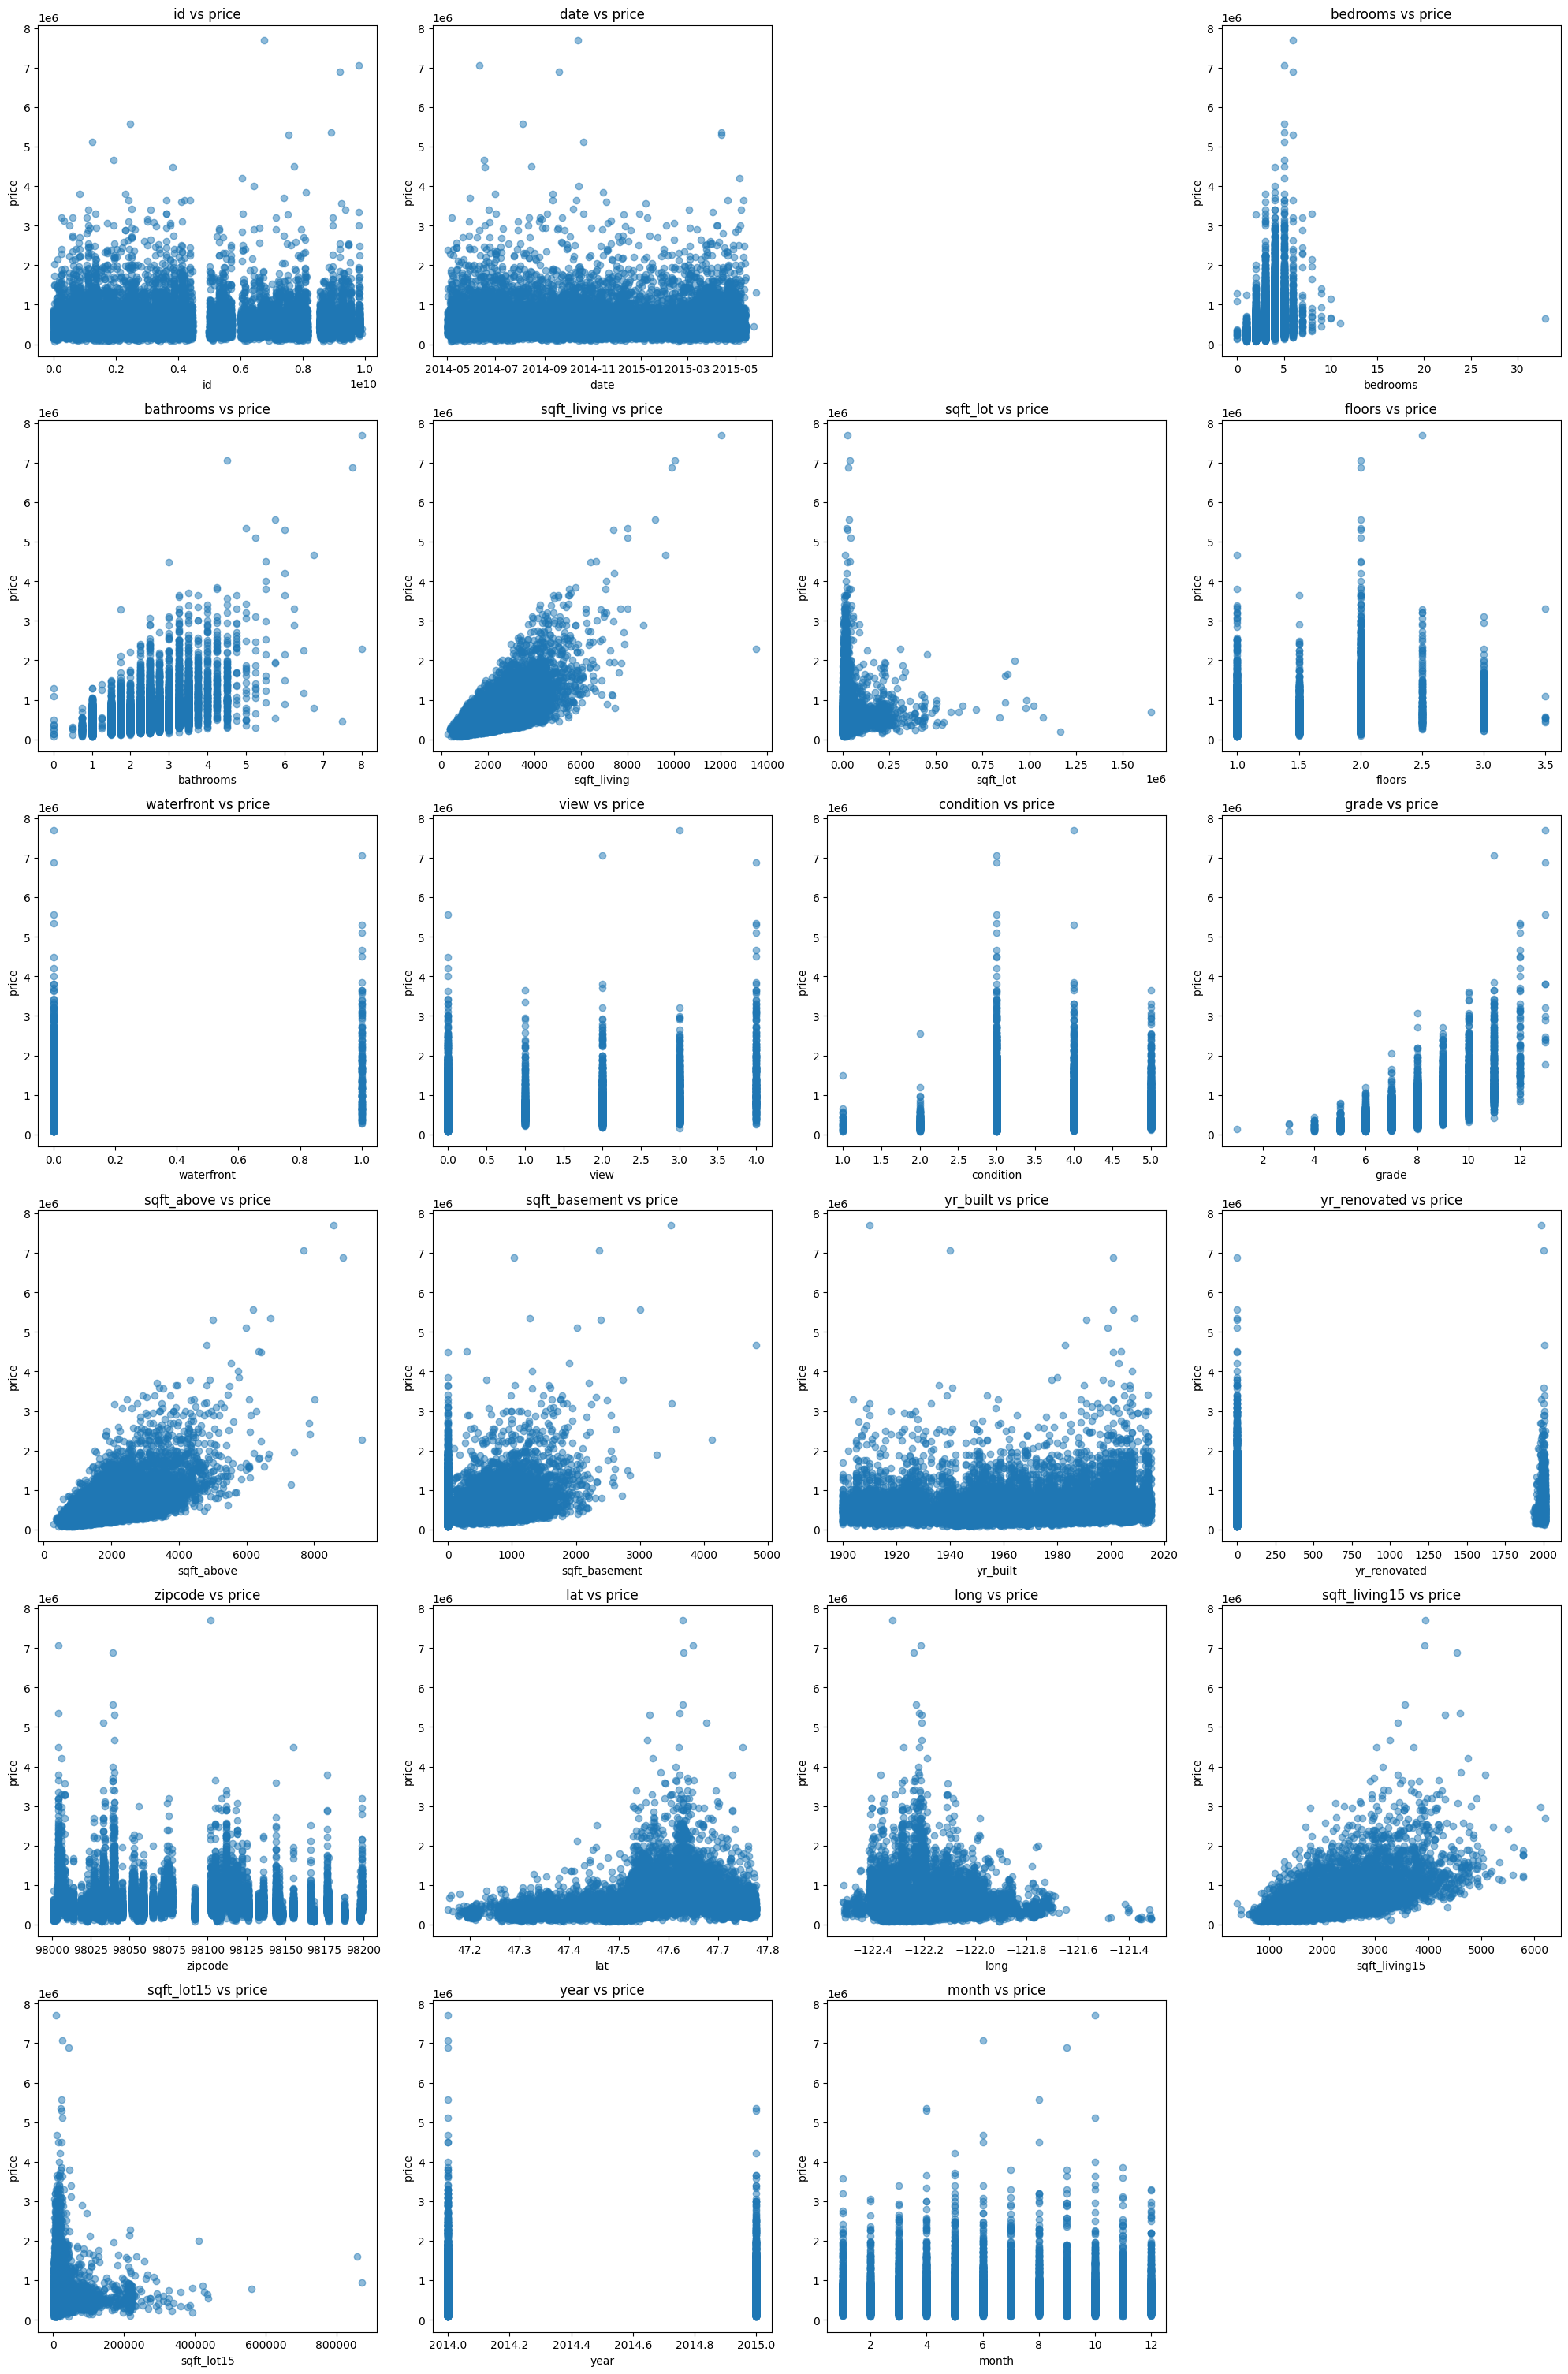

In [ ]:
def plot_all_relationships(data, target_name):
    num_features = len(data.columns) - 1  # Exclude the target column
    num_cols = 4  # Number of columns for subplots
    # Use ceiling division to ensure enough rows
    num_rows = (num_features + num_cols - 1) # // num_cols

    plt.figure(figsize=(20, 5 * num_rows))  # Adjust figure height based on rows
    for i, feature in enumerate(data.columns):
        if feature == target_name:
            continue
        # Add 1 to i to start subplot indexing from 1
        plt.subplot(num_rows, num_cols, i + 1)
        plt.scatter(data[feature], data[target_name], alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel(target_name)
        plt.title(f'{feature} vs {target_name}')
    plt.tight_layout()
    plt.show()

# Plot relationships for all independent features against the target
plot_all_relationships(data, 'price')

In [ ]:
# Example usage of predict function with user input
def get_user_input():
    user_input = {
        "bedrooms": float(input("Enter value for bedrooms: ")),
        "bathrooms": float(input("Enter value for bathrooms: ")),
        "sqft_living": float(input("Enter value for sqft_living: ")),
        "sqft_lot": float(input("Enter value for sqft_lot: ")),
        "floors": float(input("Enter value for floors: ")),
        "waterfront": float(input("Enter value for waterfront (0 or 1): ")),
        "view": float(input("Enter value for view: ")),
        "condition": float(input("Enter value for condition: ")),
        "grade": float(input("Enter value for grade: ")),
        "sqft_above": float(input("Enter value for sqft_above: ")),
        "sqft_basement": float(input("Enter value for sqft_basement: ")),
        "yr_built": float(input("Enter value for yr_built: ")),
        "yr_renovated": float(input("Enter value for yr_renovated: ")),
        "sqft_living15": float(input("Enter value for sqft_living15: ")),
        "sqft_lot15": float(input("Enter value for sqft_lot15: "))
    }
    return user_input

print("Enter the details of the house to predict its price.")
user_input = get_user_input()

# Show the user input
print("\nUser Input:")
for key, value in user_input.items():
    print(f"{key}: {value}")

predicted_price = predict_price(user_input)
print(f"\nPredicted price for the given input is ${predicted_price:.2f}")

Enter the details of the house to predict its price.
Enter value for bedrooms: 3
Enter value for bathrooms: 2
Enter value for sqft_living: 1313
Enter value for sqft_lot: 3455
Enter value for floors: 1
Enter value for waterfront (0 or 1): 0
Enter value for view: 4
Enter value for condition: 2
Enter value for grade: 88
Enter value for sqft_above: 45
Enter value for sqft_basement: 123
Enter value for yr_built: 1995
Enter value for yr_renovated: 2005
Enter value for sqft_living15: 3126
Enter value for sqft_lot15: 32

User Input:
bedrooms: 3.0
bathrooms: 2.0
sqft_living: 1313.0
sqft_lot: 3455.0
floors: 1.0
waterfront: 0.0
view: 4.0
condition: 2.0
grade: 88.0
sqft_above: 45.0
sqft_basement: 123.0
yr_built: 1995.0
yr_renovated: 2005.0
sqft_living15: 3126.0
sqft_lot15: 32.0

Predicted price for the given input is $3451892.75


**END**